In [1]:
!python -m pip install gwpy
!pip install astropy
!pip install nnAudio
!pip install -q librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import signal
from glob import glob
from PIL import Image
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
import torch
import random
from nnAudio.Spectrogram import CQT1992v2
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import numpy as np
from nnAudio.Spectrogram import CQT1992v2
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq
import librosa
import librosa.display as lbd


2025-08-29 15:12:02.208641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756480322.532844      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756480322.617930      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [3]:
# see how the data looks
file = "../input/g2net-gravitational-wave-detection/train/0/0/0/00000e74ad.npy"
data = np.load(file)
print(data.shape)
print(data)

(3, 4096)
[[-5.94830548e-21 -5.84995448e-21 -5.42415169e-21 ...
  -6.06698987e-21 -5.96345722e-21 -5.75778438e-21]
 [ 9.75407048e-22  4.52586118e-22  4.58643893e-23 ...
  -1.09608208e-20 -1.09766636e-20 -1.10858129e-20]
 [-1.74871983e-21 -1.18286791e-21 -1.93223777e-21 ...
   1.46502268e-21  2.18644864e-21  1.54085934e-21]]


In [4]:
train_paths = glob("../input/g2net-gravitational-wave-detection/train/*/*/*/*")

train_labels = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")

ids_from_npy_files = [path.split("/")[-1].split(".")[0] for path in train_paths]

df_path_id = pd.DataFrame({'path': train_paths, 'id':ids_from_npy_files})

df_path_target = pd.merge(train_labels,df_path_id,on='id')


In [5]:
#EDA, searching for the best represantion before training model
df_train_0 = df_path_target[df_path_target.target == 0]
df_train_1 = df_path_target[df_path_target.target == 1]
display(df_train_1)
#x = np.load(df_train_1.loc[0, 'path']) #[0]  # channel 0 of one sample
x = np.load("../input/g2net-gravitational-wave-detection/train/0/0/0/00000e74ad.npy")
x = np.hstack(x)

,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...
5,0000bb9f3e,1,../input/g2net-gravitational-wave-detection/tr...
7,0000d61b7b,1,../input/g2net-gravitational-wave-detection/tr...
8,0001016d12,1,../input/g2net-gravitational-wave-detection/tr...
...,...,...,...
559985,fffef24633,1,../input/g2net-gravitational-wave-detection/tr...
559988,ffff1a0fee,1,../input/g2net-gravitational-wave-detection/tr...
559994,ffff8ae576,1,../input/g2net-gravitational-wave-detection/tr...
559995,ffff9a5645,1,../input/g2net-gravitational-wave-detection/tr...


CQT kernels created, time used = 0.0328 seconds


/usr/local/lib/python3.11/dist-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


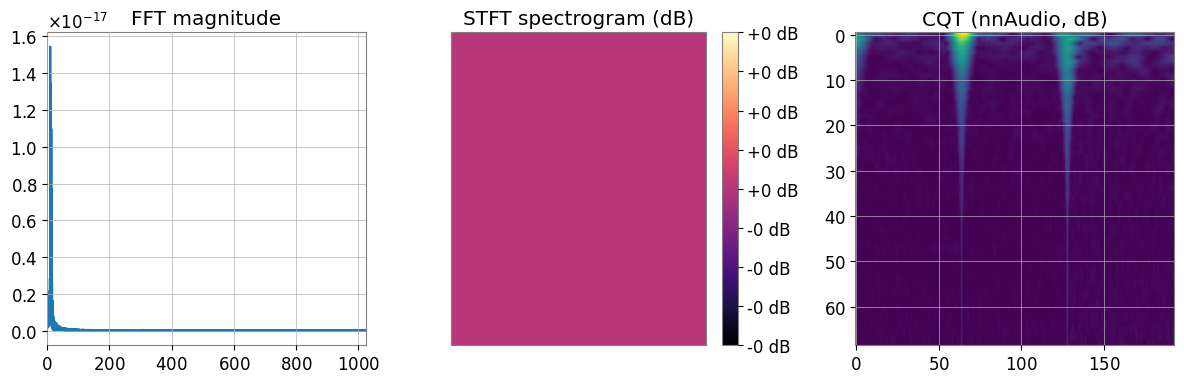

In [6]:
#EDA, comparing FFT, spectrogram, CQT transform
# -------- settings --------
FS = 2048          # sample rate (Hz)
F_MAX = 1024     # top-of-plot frequency limit for STFT/CQT/FFT (set 50 if you prefer)
F_MIN = 20
N_FFT = 256        # STFT window size
HOP = 64          # STFT/CQT hop length
# ---------- FFT ----------
X = np.abs(rfft(x))
f = rfftfreq(len(x), d=1/FS)

# ---------- STFT ----------
S = np.abs(librosa.stft(x, n_fft=N_FFT, hop_length=HOP, window='hann'))**2  # power
S_db = librosa.power_to_db(S, ref=np.max)

# ---------- CQT (nnAudio) ----------
# nnAudio expects a torch tensor shaped [batch, time]
x_t = torch.from_numpy(x).float()

cqt_transform = CQT1992v2(
    sr=FS,
    hop_length=HOP,
    fmin=F_MIN,
    fmax=F_MAX
)

cqt = cqt_transform(x_t)[0]

# ---------- plot all in one figure ----------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# FFT
axes[0].plot(f, X)
axes[0].set_xlim(0, F_MAX)
axes[0].set_title("FFT magnitude")
axes[0].grid(True)

# STFT spectrogram
img1 = lbd.specshow(
    S_db, sr=FS, hop_length=HOP,ax=axes[1]
)
axes[1].set_title("STFT spectrogram (dB)")
fig.colorbar(img1, ax=axes[1], format='%+2.0f dB')

#CQT (nnAudio)

axes[2].imshow(cqt,aspect='auto')
axes[2].set_title("CQT (nnAudio, dB)")
plt.tight_layout()
plt.show()


look like CQT gives a good represantion of the data

now we have 2 different approach: 
1) raw data -> CQT -> deep learning model (specificly 2D CNN)
2) raw data -> deep learning model (which one?)

we'll try both